In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from denoising.helpers import *
from denoising.connectivity import *
from denoising.metrics import ICC
from nilearn.connectome import sym_matrix_to_vec
from seaborn import heatmap
import numpy as np
from scipy.stats import zscore

from scipy.stats import ttest_1samp

In [3]:
atlas = 'HCPex' # Schaefer200 AAL Brainnetome
strategy = 4

In [58]:
trt1 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=1, atlas_name=atlas, strategy=strategy)
trt2 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=2, atlas_name=atlas, strategy=strategy)
trt3 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=3, atlas_name=atlas, strategy=strategy)

NameError: name 'atlas' is not defined

In [59]:
trt1 = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\roi\trt_roi_HCPex_ses-1.npy')
trt2 = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\roi\trt_roi_HCPex_ses-2.npy')
trt3 = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\roi\trt_roi_HCPex_ses-3.npy')

In [4]:
opened = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\roi\ihb_open_roi_HCPex.npy')
closed = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\roi\ihb_close_roi_HCPex.npy')

In [5]:
fc_op = functional_connectivity(opened, 'correlation')
fc_cl = functional_connectivity(closed, 'correlation')

In [20]:
opened_1 = opened[:, :60, :]
opened_2 = opened[:, 60:, :]

fc_op1 = functional_connectivity(opened_1, 'correlation')
fc_op2 = functional_connectivity(opened_2, 'correlation')

closed_1 = closed[:, :60, :]
closed_2 = closed[:, 60:, :]

fc_cl1 = functional_connectivity(closed_1, 'correlation')
fc_cl2 = functional_connectivity(closed_2, 'correlation')

In [74]:
fc_cl1 = zscore(fc_cl1)
fc_cl2 = zscore(fc_cl2)

In [23]:
cat_op = np.concatenate((fc_op1, fc_op2))
cat_cl = np.concatenate((fc_cl1, fc_cl2))

<Axes: >

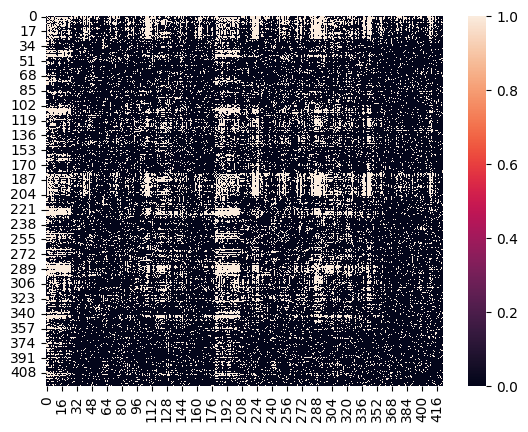

In [24]:
t_stat, p_val = ttest_1samp(cat_op - cat_cl, 0)
heatmap(p_val < 0.05)

In [27]:
cor = p_val < 0.05
cat1 = np.concatenate((fc_op1 * cor, fc_cl1 * cor))
cat2 = np.concatenate((fc_op2 * cor, fc_cl2 * cor))

In [28]:
sh = len(cat1)
m = np.zeros((sh, sh))
for i in range(sh):
    for t in range(sh):
        m[i, t] = np.corrcoef(cat1[i].flatten(), cat2[t].flatten())[0, 1]

In [40]:
idx = 44
m[idx, idx] - (np.sum(m[idx, :84]) - m[idx, idx]) / 83

0.3245630031954355

<Axes: >

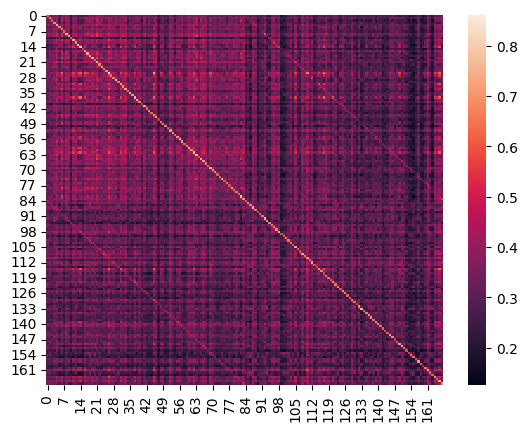

In [29]:
heatmap(m)

In [60]:
fc_trt1 = functional_connectivity(trt1, 'correlation')
fc_trt2 = functional_connectivity(trt2, 'correlation')
fc_trt3 = functional_connectivity(trt3, 'correlation')

In [4]:
#fc_trt1 = np.load(r'C:\Users\ТМ\Desktop\OpenCloseProject\lasso_trt_ses-1_HCPex.npy')
#fc_trt2 = np.load(r'C:\Users\ТМ\Desktop\OpenCloseProject\lasso_trt_ses-2_HCPex.npy')
#fc_trt3 = np.load(r'C:\Users\ТМ\Desktop\OpenCloseProject\lasso_trt_ses-3_HCPex.npy')

In [4]:
import numpy as np
from typing import List
from numpy.typing import NDArray


class ICC:
    def __init__(self, data: List[NDArray], use_mask=False, mask_file=None):
        """
        Class to calculate ICC.

        Parameters
        ----------
        data: list
            list of data for every session to compute metrics
            one session - np.array, vector of functional connectivity
            Note! for BSS calculation only two sessions should be passed
        mask_file: None or np.array, optional
            mask to be used to exclude zero elements (for simulations)

        """
        self.n_ses = len(data)
        self.n_sub = len(data[0])
        self.data = data

        if use_mask:
            
            self.thrsh = 0.2

            if mask_file is None:
                self.mask = [np.array(d > self.thrsh) for d in data] # 2
                self.data = [data[i][self.mask[i]] for i in range(self.n_ses)] # 2

                # len(self.data) = 2
                # self.data[0].shape = (n_sub, roi, roi)
            else:
                self.mask = [np.array([mask_file for _ in range(self.n_sub)]) for _ in range(self.n_ses)]
                self.data = [data[i] * self.mask[i] for i in range(self.n_ses)]


    @property
    def _avg_matr(self):
        return np.mean(
            np.concatenate(self.data), axis=0)
    

    def _bms(self) -> float:
        """
        Calculates the sum of squared between-subj variance,
        the average subject value subtracted from overall avg of values

        """
        # group vecs by subject
        sub_matr = [[self.data[ses][sub] for ses in range(self.n_ses)] for sub in range(self.n_sub)] # list(list*2)*nsub
        
        return np.sum([(self._avg_matr - 
                        np.mean(sub_matr[sub], axis=0)) **2 for sub in range(self.n_sub)], axis=0) * self.n_ses


    def _wms(self) -> float:
        """
        calculates the sum of squared Intra-subj variance,
        the average session value subtracted from overall avg of values

        """
        return np.sum([(self._avg_matr - 
                        np.mean(self.data[ses], axis=0)) **2 for ses in range(self.n_ses)], axis=0) * self.n_sub


    def icc(self) -> NDArray:
        """
        icc metric

        """
        bms = self._bms()
        wms = self._wms()
        print(np.mean(bms), np.mean(wms))
        icc =  ((bms - wms) / 
                (1e-09 + bms + (self.n_ses - 1) * wms))
        return icc

In [77]:
class ICC:
    def __init__(self, data):
        self.data = data
        self.k = data.shape[1] # ses
        self.n = data.shape[0] # sub

    def sstotal(self):
        return np.var(self.data) * (self.k * self.n - 1)
    
    def msr(self):
        return np.var(np.mean(self.data, axis=1)) * self.k
    
    def msc(self):
        return np.var(np.mean(self.data, axis=0)) * self.n
    
    def mse(self):
        return (self.sstotal() - self.msr() * (self.n -1) - self.msc() * (self.k - 1)) / (self.n - 1) * (self.k - 1)
    
    def icc(self):
        return (self.msr() - self.mse()) / (self.msr() + (self.k - 1) * self.mse())

In [44]:
# 84, 2, 426, 426

np.concatenate((fc_cl, fc_op), 1).shape

(84, 846, 423)

In [46]:
test = np.zeros((84, 2, 423, 423))

test[0, 1, :, :] = fc_op[0]

In [49]:
op_cl = np.zeros((84, 2, 423, 423))
for i in range(84):
    op_cl[i, 0] = fc_op[i]
    op_cl[i, 1] = fc_cl[i]

In [61]:
fc_trt1.shape

(22, 423, 423)

In [73]:
trt = np.zeros((22, 3, 423, 423))
for i in range(22):
    trt[i, 0] = fc_trt1[i]
    trt[i, 1] = fc_trt2[i]
    trt[i, 2] = fc_trt3[i]

In [78]:
metric = ICC(trt)

In [79]:
metric.icc()

0.047914602090763744

In [72]:
metric.msr(), metric.msc(), metric.mse()

(0.017570646409540373, 0.0668838263254879, 0.0044996837410064446)

In [80]:
metric.sstotal()

0.8203672589027053

In [12]:
fc_op.shape

(84, 423, 423)

In [15]:
metric = ICC([fc_trt2, fc_trt1], use_mask=False)
outp = metric.icc()

In [81]:
np.fill_diagonal(outp, 0)

0.9757017726914404


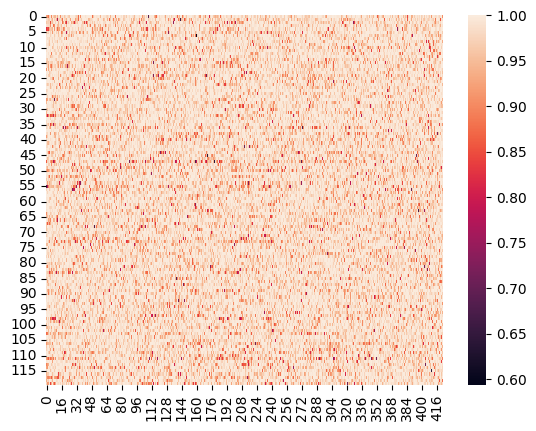

In [14]:
print(np.mean(outp))
heatmap(outp);

In [11]:
def discriminability(icc):
    return 0.5 + (1 / np.pi) * np.arctan(icc / np.sqrt((1 - icc) * (3 + icc)))

In [31]:
dsc = discriminability(outp)
print(np.mean(dsc))
#heatmap(dsc);#.shape

0.7025652381844875
